# __<font color=#e86c64>Boxing Classification</font>__

## Introduction
This project aims to create an innovative multi-classification system for boxing punches, utilizing advanced machine learning techniques. By analyzing diverse datasets of boxing punches, including jabs, lead hooks, rear hooks, lead uppercuts, rear uppercuts, and crosses, the system will provide real-time identification and feedback. 




## Dependencies and Setup


In [562]:
!pip install tensorflow opencv-python matplotlib
!pip install keras

In [563]:
!pip list

Package                       Version
----------------------------- ---------
absl-py                       1.4.0
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.8.3
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anaconda-catalogs             0.2.0
anaconda-client               1.11.3
anaconda-navigator            2.4.2
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
applaunchservices             0.3.0
appnope                       0.1.2
appscript                     1.1.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites    

In [564]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.utils import to_categorical
import os
from matplotlib import pyplot as plt
import cv2
import imghdr
import numpy as np

## Removing Faulty Images


In [565]:
data_dir = "data"

In [566]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [567]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

## Loading Data

In [568]:
data = tf.keras.utils.image_dataset_from_directory('data')


Found 508 files belonging to 6 classes.


In [569]:
data_iterator = data.as_numpy_iterator()

In [570]:
batch = data_iterator.next()

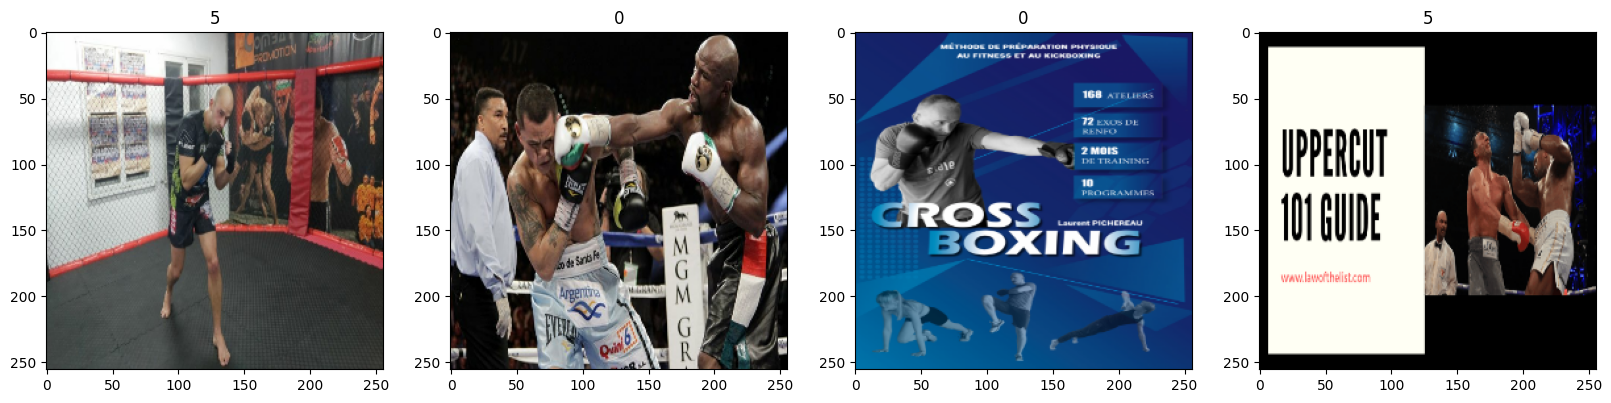

In [571]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Preprocessing Data

### Scaling Data


In [572]:
data = data.map(lambda x,y: (x/255, y))

In [573]:
data.as_numpy_iterator().next()


(array([[[[0.44705883, 0.39607844, 0.33333334],
          [0.44705883, 0.39607844, 0.33333334],
          [0.44874388, 0.3977635 , 0.3350184 ],
          ...,
          [0.36133578, 0.31427696, 0.25153187],
          [0.37052697, 0.33219975, 0.27236518],
          [0.3833027 , 0.34800857, 0.28918505]],
 
         [[0.44705883, 0.39607844, 0.33333334],
          [0.44705883, 0.39607844, 0.33333334],
          [0.44874388, 0.3977635 , 0.3350184 ],
          ...,
          [0.365951  , 0.31807598, 0.2553309 ],
          [0.37714556, 0.33458897, 0.2761642 ],
          [0.3874282 , 0.35164437, 0.29298407]],
 
         [[0.44650736, 0.39552698, 0.33278185],
          [0.44650736, 0.39552698, 0.33278185],
          [0.4481924 , 0.397212  , 0.3344669 ],
          ...,
          [0.3728329 , 0.32440352, 0.26079246],
          [0.38598776, 0.33907112, 0.28104416],
          [0.3949865 , 0.35716912, 0.29808372]],
 
         ...,
 
         [[0.40133417, 0.3622104 , 0.29670793],
          [0.40457

### Splitting Data


In [574]:
training_size = int(len(data)*.7)
validate_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)


In [575]:
train = data.take(training_size)
val = data.skip(training_size).take(validate_size)
test = data.skip(training_size+validate_size).take(test_size)


## Building Model


In [576]:
from keras.layers import BatchNormalization
model = Sequential()


In [577]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(6, activation='softmax'))


In [578]:

optimize = keras.optimizers.legacy.Adam(learning_rate=0.0001)
model.compile(optimizer=optimize, loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [579]:
model.summary()


Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_162 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_122 (MaxPool  (None, 127, 127, 16)      0         
 ing2D)                                                          
                                                                 
 conv2d_163 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_123 (MaxPool  (None, 62, 62, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_164 (Conv2D)         (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_124 (MaxPool  (None, 30, 30, 16)      

## Training Model


In [580]:
logdir='logs'

In [581]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [582]:
hist = model.fit(train, epochs=60, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/60
11/11 [==============================] - 4s 283ms/step - loss: 1.8106 - accuracy: 0.1818 - val_loss: 1.7462 - val_accuracy: 0.2031
Epoch 2/60
11/11 [==============================] - 3s 273ms/step - loss: 1.7574 - accuracy: 0.2585 - val_loss: 1.7299 - val_accuracy: 0.3359
Epoch 3/60
11/11 [==============================] - 4s 282ms/step - loss: 1.7127 - accuracy: 0.2756 - val_loss: 1.6832 - val_accuracy: 0.3438
Epoch 4/60
11/11 [==============================] - 4s 275ms/step - loss: 1.6602 - accuracy: 0.4403 - val_loss: 1.6100 - val_accuracy: 0.4766
Epoch 5/60
11/11 [==============================] - 4s 279ms/step - loss: 1.5900 - accuracy: 0.4091 - val_loss: 1.5886 - val_accuracy: 0.4531
Epoch 6/60
11/11 [==============================] - 4s 283ms/step - loss: 1.4831 - accuracy: 0.5057 - val_loss: 1.4415 - val_accuracy: 0.4688
Epoch 7/60
11/11 [==============================] - 4s 278ms/step - loss: 1.4376 - accuracy: 0.4716 - val_loss: 1.3456 - val_accuracy: 0.5078
Epoch 

## Plot Depiction


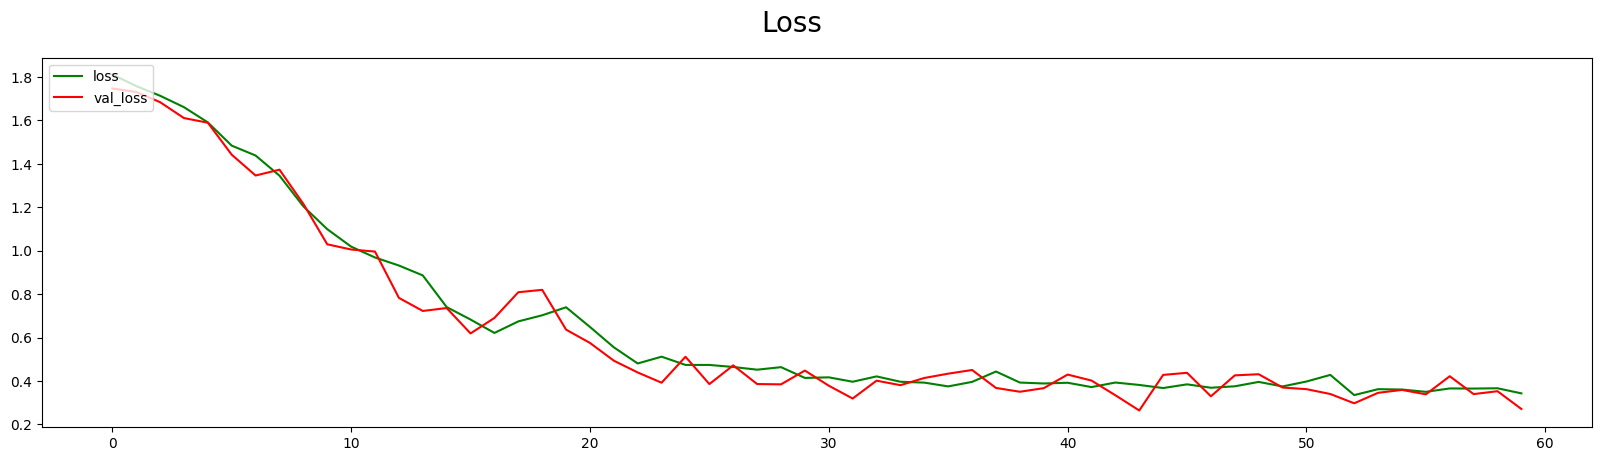

In [583]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='green', label='loss')
plt.plot(hist.history['val_loss'], color='red', label='val_loss')
fig.suptitle('Loss', fontsize=20)
fig.set_figwidth(20)             
plt.legend(loc="upper left")
plt.show()

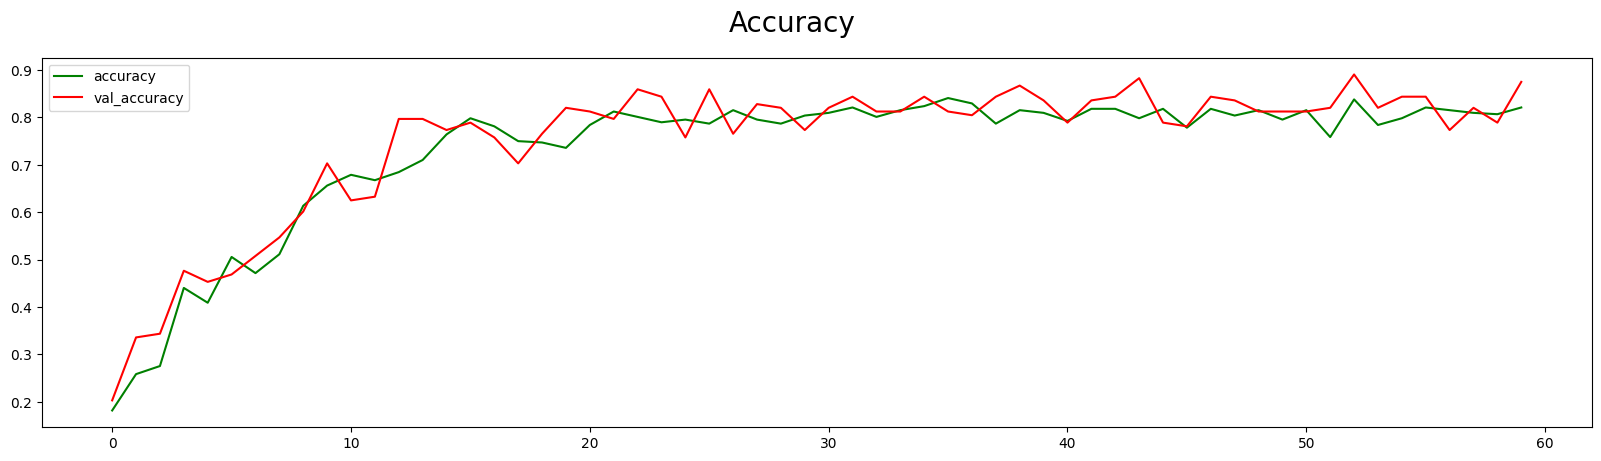

In [584]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='green', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='red', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
fig.set_figwidth(20)             
plt.legend(loc="upper left")
plt.show()

## Evaluating Model


In [591]:
from keras.metrics import Precision, Recall, CategoricalAccuracy

In [595]:
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

In [600]:
# for batch in test.as_numpy_iterator():
#     X, y = batch
#     yhat = model.predict(X)    
#     precision.update_state(y, yhat)
#     recall.update_state(y, yhat)
#     accuracy.update_state(y, yhat)

In [601]:
# precision_result = precision.result().numpy()
# recall_result = recall.result().numpy()
# accuracy_result = accuracy.result().numpy()

## Testing Model


In [608]:
import cv2


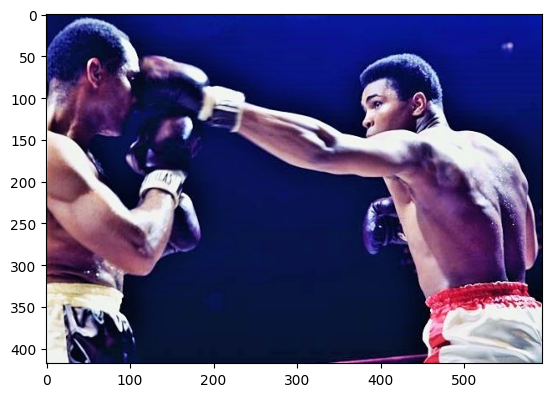

In [745]:
img = cv2.imread('jab-test.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [746]:
resize = tf.image.resize(img, (256, 256))
np.expand_dims(resize, 0)

array([[[[ 82.34375  ,  13.0234375,   6.0234375],
         [ 95.63118  ,  17.670242 ,  11.670242 ],
         [ 94.09766  ,  17.       ,   9.699219 ],
         ...,
         [162.       ,  24.       ,   6.       ],
         [164.01953  ,  26.019531 ,   8.019531 ],
         [167.       ,  29.       ,  11.       ]],

        [[ 79.43913  ,  12.339844 ,   5.0172577],
         [ 94.90532  ,  16.98146  ,  10.981461 ],
         [ 94.09766  ,  17.       ,   9.699219 ],
         ...,
         [162.       ,  24.       ,   6.       ],
         [164.01953  ,  26.019531 ,   8.019531 ],
         [167.       ,  29.       ,  11.       ]],

        [[ 78.32031  ,  11.339844 ,   4.       ],
         [ 92.34801  ,  16.409805 ,  10.3984375],
         [ 92.93359  ,  17.406967 ,   9.699219 ],
         ...,
         [162.       ,  24.       ,   6.       ],
         [163.03906  ,  25.039062 ,   7.0390625],
         [166.14204  ,  28.142044 ,  10.142044 ]],

        ...,

        [[243.9968   , 240.51491  , 24

In [747]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 14ms/step


In [748]:
yhat

array([[6.9179110e-02, 9.2811525e-01, 4.1396456e-04, 1.5649514e-04,
        1.6472529e-03, 4.8798003e-04]], dtype=float32)

In [749]:
classes = ['Cross', 'Jab', 'Lead Hook', 'Lead Uppercut', 'Rear Hook', 'Rear Uppercut']
for index, label in enumerate(yhat[0]):
    print(classes[index] + ': ', label*100)

Cross:  6.917911022901535
Jab:  92.81152486801147
Lead Hook:  0.04139645607210696
Lead Uppercut:  0.01564951380714774
Rear Hook:  0.1647252938710153
Rear Uppercut:  0.04879800253547728


## <font color=green>Working!</font>
